## Predict their clients' repayment abilities

In [1]:
folder = r"G:\Study material\Data Science\Datasets\Mckinsey_Insurance"
#r"/home/ws01/Documents/Datasets/Mckinsey_Insurance"
seed = 24

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Basic libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import gc
import time

In [4]:
#Visualization libraries
from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 20, 8

In [5]:
#modelling libraries
from sklearn.preprocessing import StandardScaler,LabelEncoder
#Train, test split and normalizing 
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV,cross_val_score

#Metric
from sklearn.metrics import roc_auc_score

import xgboost as xgb
from xgboost import XGBClassifier as xgc

In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.precision', 3)

In [7]:
train = pd.read_csv(os.path.join(folder,"train.csv"))
train.shape

(79853, 13)

In [8]:
train.head()

,id,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal
0,110936,0.429,12058,355060,0.0,0.0,0.0,99.02,13,C,Urban,3300,1
1,41492,0.010,21546,315150,0.0,0.0,0.0,99.89,21,A,Urban,18000,1
2,31300,0.917,17531,84140,2.0,3.0,1.0,98.69,7,C,Rural,3300,0
3,19415,0.049,15341,250510,0.0,0.0,0.0,99.57,9,A,Urban,9600,1
4,99379,0.052,31400,198680,0.0,0.0,0.0,99.87,12,B,Urban,9600,1


In [9]:
id_col = 'id'

In [10]:
target = train['renewal']

In [11]:
test = pd.read_csv(os.path.join(folder,"test.csv"))
test.shape

(34224, 12)

In [12]:
train.set_index(id_col,inplace=True)
test.set_index(id_col,inplace=True)

In [13]:
target.value_counts(normalize=True).round(3) *100 #Imbalanced

1    93.7
0     6.3
Name: renewal, dtype: float64

In [14]:
train.dtypes.value_counts()

float64    5
int64      5
object     2
dtype: int64

In [15]:
train[train.isnull().any(axis=1)].shape #empty rows

(2998, 12)

In [16]:
def info(df,sort = True,save = "No"):
    size = df.shape[0]
    null = df.isnull().sum()
    nuni = df.nunique()
    dtype = df.dtypes
    missing_pct = null*100/size
    df_info  = pd.concat([dtype, missing_pct.round(2),nuni], axis=1, keys=['type','missing','nunique'])
    if sort == True:
        df_info.sort_values (['missing'],ascending=False,inplace=True)
    if (save == "Yes"):
        df_info.to_csv(os.path.join(folder,'info.csv'))
    return df_info

In [17]:
def create_cat(df,col,values):
    prefix = col
    unique_vals = values #list(df[col].unique())    
    dummies = pd.DataFrame()
    for val in unique_vals:
        dummies[prefix + "_" + val] = df[col] == val
        dummies[prefix + "_" + val] = dummies[prefix + "_" + val].apply(lambda x: 1 if x == True else 0)
            #le = LabelEncoder()
            #dummies[prefix + "_" + val] = le.fit_transform(dummies[prefix + "_" + val])
    
    df = pd.concat([df,dummies],axis=1)
    return df 

In [18]:
def cat_all(train,test,cols):
    #For example, one has to create dummies for zip code
    for col in cols:
        highest_cat = train[col].value_counts().index[0]
        values_cat = [i for i in list(train[col].unique()) if i not in [highest_cat]]

        start = time.time()
        train = create_cat(train,col,values_cat)
        print("Time taken: ", time.time() - start)
        train.drop(col,axis=1, inplace=True)

        test = create_cat(test,col,values_cat)
        print("Time taken: ", time.time() - start)
        test.drop(col,axis=1, inplace=True)
    
    return train,test

In [19]:
train_info = info(train,False,'Yes')

In [20]:
train_info.sort_values('missing',inplace=True, ascending=False)

In [21]:
train_info.T

,application_underwriting_score,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,perc_premium_paid_by_cash_credit,age_in_days,Income,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal
type,float64,float64,float64,float64,float64,int64,int64,int64,object,object,int64,int64
missing,3.72,0.12,0.12,0.12,0,0,0,0,0,0,0,0
nunique,672,14,17,10,1001,833,24165,57,5,2,30,2


In [22]:
drop_missing = list(train_info[train_info['missing'] > 40].index)

In [23]:
drop_missing

[]

In [24]:
train.drop(drop_missing, axis =1 , inplace = True)
test.drop(drop_missing, axis =1 , inplace = True)

In [25]:
#Explore columns

In [26]:
train[train['Count_3-6_months_late'].isnull() == 1]

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal
id,,,,,,,,,,,,
73099,1.0,15336,210100,NaN,NaN,NaN,NaN,2,A,Urban,9600,0
81690,1.0,7679,39040,NaN,NaN,NaN,NaN,2,A,Rural,1200,0
49862,1.0,10593,49520,NaN,NaN,NaN,NaN,2,A,Rural,1200,0
59,1.0,17891,90100,NaN,NaN,NaN,NaN,2,A,Urban,5700,1
19184,1.0,18260,40530,NaN,NaN,NaN,NaN,2,A,Rural,1200,0
74860,1.0,17535,36130,NaN,NaN,NaN,NaN,2,A,Urban,5700,0
61476,1.0,9139,90090,NaN,NaN,NaN,NaN,2,A,Urban,5400,1
52266,1.0,9501,30040,NaN,NaN,NaN,NaN,2,A,Urban,1200,0
14736,1.0,14612,216650,NaN,NaN,NaN,NaN,2,C,Rural,1200,1


In [27]:
target.value_counts()

1    74855
0     4998
Name: renewal, dtype: int64

In [28]:
train[train['Count_3-6_months_late'].isnull() == 1].renewal.value_counts()

0    60
1    37
Name: renewal, dtype: int64

In [29]:
train['Count_3-6_months_late'].describe()

count    79756.000
mean         0.249
std          0.691
min          0.000
25%          0.000
50%          0.000
75%          0.000
max         13.000
Name: Count_3-6_months_late, dtype: float64

In [30]:
print(train[train['Count_3-6_months_late'].isnull() == 1].no_of_premiums_paid.unique())
print(train[train['Count_6-12_months_late'].isnull() == 1].no_of_premiums_paid.unique())
print(train[train['Count_more_than_12_months_late'].isnull() == 1].no_of_premiums_paid.unique())
#Count_3-6_months_late is empty when the customers are look in perioed as shown by num of premiums paid 2 - 3 months

[2 3]
[2 3]
[2 3]


In [31]:
train[train[train['Count_3-6_months_late'].isnull() == 1] == \
      train[train['Count_6-12_months_late'].isnull() == 1]]\
    .perc_premium_paid_by_cash_credit.sum()

97.0

In [32]:
train[train[train['Count_3-6_months_late'].isnull() == 1] == \
      train[train['Count_more_than_12_months_late'].isnull() == 1]]\
    .perc_premium_paid_by_cash_credit.sum()

97.0

In [33]:
train[train[train['Count_6-12_months_late'].isnull() == 1] == \
      train[train['Count_more_than_12_months_late'].isnull() == 1]]\
    .perc_premium_paid_by_cash_credit.sum()

97.0

In [34]:
#Impute with zero months
#Should be handled separately later on for incentives on customer retention
cols = ['Count_3-6_months_late','Count_6-12_months_late','Count_more_than_12_months_late']
for col in cols:
    train[col].fillna(0,inplace=True)
    test[col].fillna(0,inplace=True)

In [35]:
#Why is there no application_underwriting_score
train[train.application_underwriting_score.isnull() == 1].head()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,sourcing_channel,residence_area_type,premium,renewal
id,,,,,,,,,,,,
68260,0.012,16433,87530,0.0,0.0,0.0,NaN,5,A,Rural,3300,1
27507,0.000,8406,24690,0.0,0.0,0.0,NaN,4,A,Urban,1200,1
60644,0.000,16799,99230,0.0,0.0,0.0,NaN,6,A,Rural,5700,1
48944,0.000,20810,150120,0.0,0.0,0.0,NaN,5,A,Urban,7500,1
91494,0.000,13875,125060,0.0,0.0,0.0,NaN,10,B,Urban,11700,1


In [36]:
train.application_underwriting_score.describe()

count    76879.000
mean        99.067
std          0.740
min         91.900
25%         98.810
50%         99.210
75%         99.540
max         99.890
Name: application_underwriting_score, dtype: float64

In [37]:
train.describe()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,renewal
count,79853.000,79853.000,7.985e+04,79853.000,79853.000,79853.000,76879.000,79853.000,79853.000,79853.000
mean,0.314,18846.697,2.088e+05,0.248,0.078,0.060,99.067,10.864,10924.508,0.937
std,0.335,5208.719,4.966e+05,0.691,0.436,0.312,0.740,5.171,9401.677,0.242
min,0.000,7670.000,2.403e+04,0.000,0.000,0.000,91.900,2.000,1200.000,0.000
25%,0.034,14974.000,1.080e+05,0.000,0.000,0.000,98.810,7.000,5400.000,1.000
50%,0.167,18625.000,1.666e+05,0.000,0.000,0.000,99.210,10.000,7500.000,1.000
75%,0.538,22636.000,2.521e+05,0.000,0.000,0.000,99.540,14.000,13800.000,1.000
max,1.000,37602.000,9.026e+07,13.000,17.000,11.000,99.890,60.000,60000.000,1.000


In [38]:
#application_underwriting_score
train[train.application_underwriting_score.isnull() == 1].describe()

,perc_premium_paid_by_cash_credit,age_in_days,Income,Count_3-6_months_late,Count_6-12_months_late,Count_more_than_12_months_late,application_underwriting_score,no_of_premiums_paid,premium,renewal
count,2974.000,2974.000,2.974e+03,2974.000,2974.000,2974.000,0.0,2974.000,2974.000,2974.000
mean,0.296,20029.381,2.101e+05,0.095,0.109,0.029,NaN,6.009,8816.409,0.933
std,0.440,7345.673,1.758e+06,0.391,0.556,0.202,NaN,4.329,8698.405,0.250
min,0.000,7670.000,2.403e+04,0.000,0.000,0.000,NaN,2.000,1200.000,0.000
25%,0.000,13875.000,7.210e+04,0.000,0.000,0.000,NaN,3.000,3300.000,1.000
50%,0.007,20445.500,1.200e+05,0.000,0.000,0.000,NaN,5.000,5700.000,1.000
75%,1.000,25930.000,2.002e+05,0.000,0.000,0.000,NaN,8.000,11700.000,1.000
max,1.000,37602.000,9.026e+07,6.000,13.000,5.000,NaN,60.000,60000.000,1.000


In [39]:
train[train.application_underwriting_score.isnull() == 1].renewal.value_counts(normalize = True)* 100

1    93.275
0     6.725
Name: renewal, dtype: float64

Empty and non empty underwriting score has same renewal value counts, which suggests that empty underwriting score is not distorting anything. Hence it can be imputed by 90 as under 90 cannot be insured

In [40]:
train.application_underwriting_score.describe()

count    76879.000
mean        99.067
std          0.740
min         91.900
25%         98.810
50%         99.210
75%         99.540
max         99.890
Name: application_underwriting_score, dtype: float64

In [41]:
train.application_underwriting_score.fillna(90, inplace = True)
test.application_underwriting_score.fillna(90, inplace = True)

In [42]:
train[train.isnull().any(axis=1)].shape

(0, 12)

In [43]:
test[test.isnull().any(axis=1)].shape

(0, 11)

In [44]:
train['age_in_years'] = train['age_in_days'].apply(lambda x: round(x/365.25))
test['age_in_years'] = test['age_in_days'].apply(lambda x: round(x/365.25))

In [45]:
train.drop('age_in_days',axis=1,inplace=True)
test.drop('age_in_days',axis=1,inplace=True)

In [46]:
train['age_in_years'].describe()

count    79853.000
mean        51.607
std         14.270
min         21.000
25%         41.000
50%         51.000
75%         62.000
max        103.000
Name: age_in_years, dtype: float64

In [47]:
age = pd.DataFrame(train['age_in_years'].value_counts())
age.reset_index(inplace=True)

In [48]:
age.head()

,index,age_in_years
0,49,2200
1,46,2108
2,47,2103
3,48,2095
4,50,2061


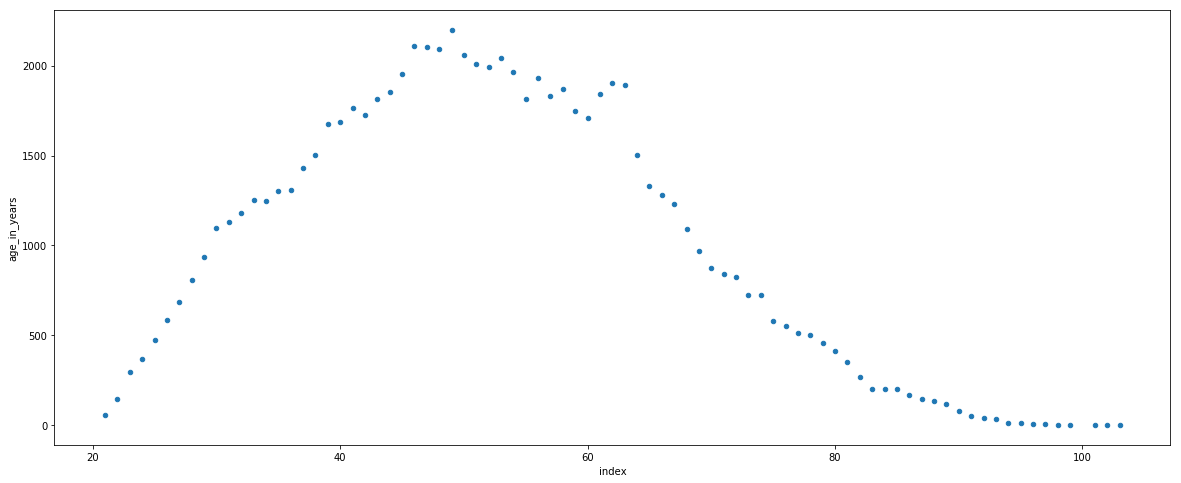

In [49]:
age.plot('index','age_in_years',kind='scatter')
plt.show() #right long tail

In [50]:
age.shape

(82, 2)

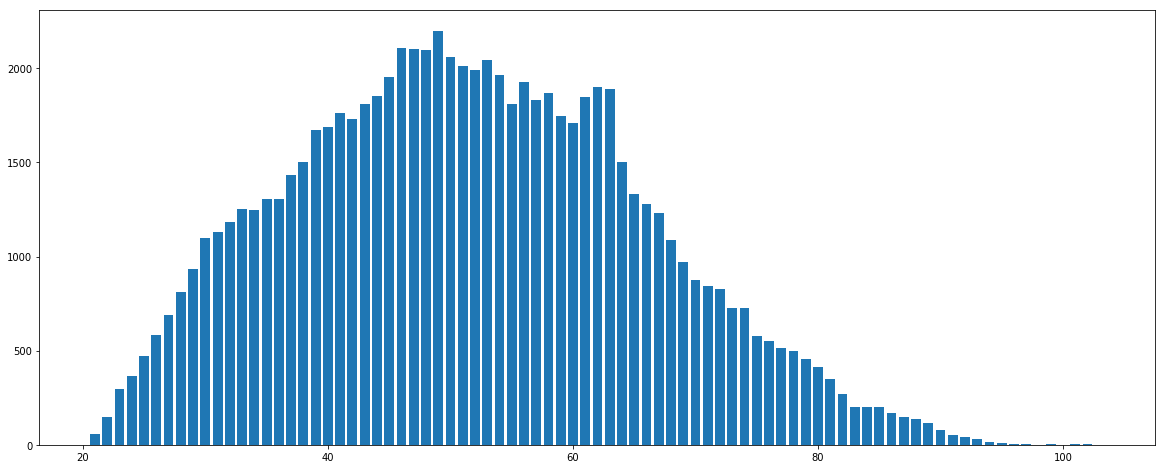

In [51]:
plt.bar(train['age_in_years'].value_counts().index,train['age_in_years'].value_counts().values)
plt.show()

In [52]:
#null category columns
cat_col = train.dtypes[train.dtypes == "object"].index

In [53]:
cat_col

Index(['sourcing_channel', 'residence_area_type'], dtype='object')

In [54]:
#Fill NA by No_value
train[cat_col] = train[cat_col].fillna('missing')
test[cat_col] = test[cat_col].fillna('missing')

In [55]:
#Missing values in numeric columns
#train = train.fillna(-1) #-1 may distort column distribution; alternate is to impute by median
#test = test.fillna(-1)

In [56]:
train[train.isnull().any(axis=1)].shape

(0, 12)

In [57]:
test[test.isnull().any(axis=1)].shape

(0, 11)

In [ ]:
#Remove outliers

In [58]:
numeric_feats = train.dtypes[train.dtypes != "object"].index

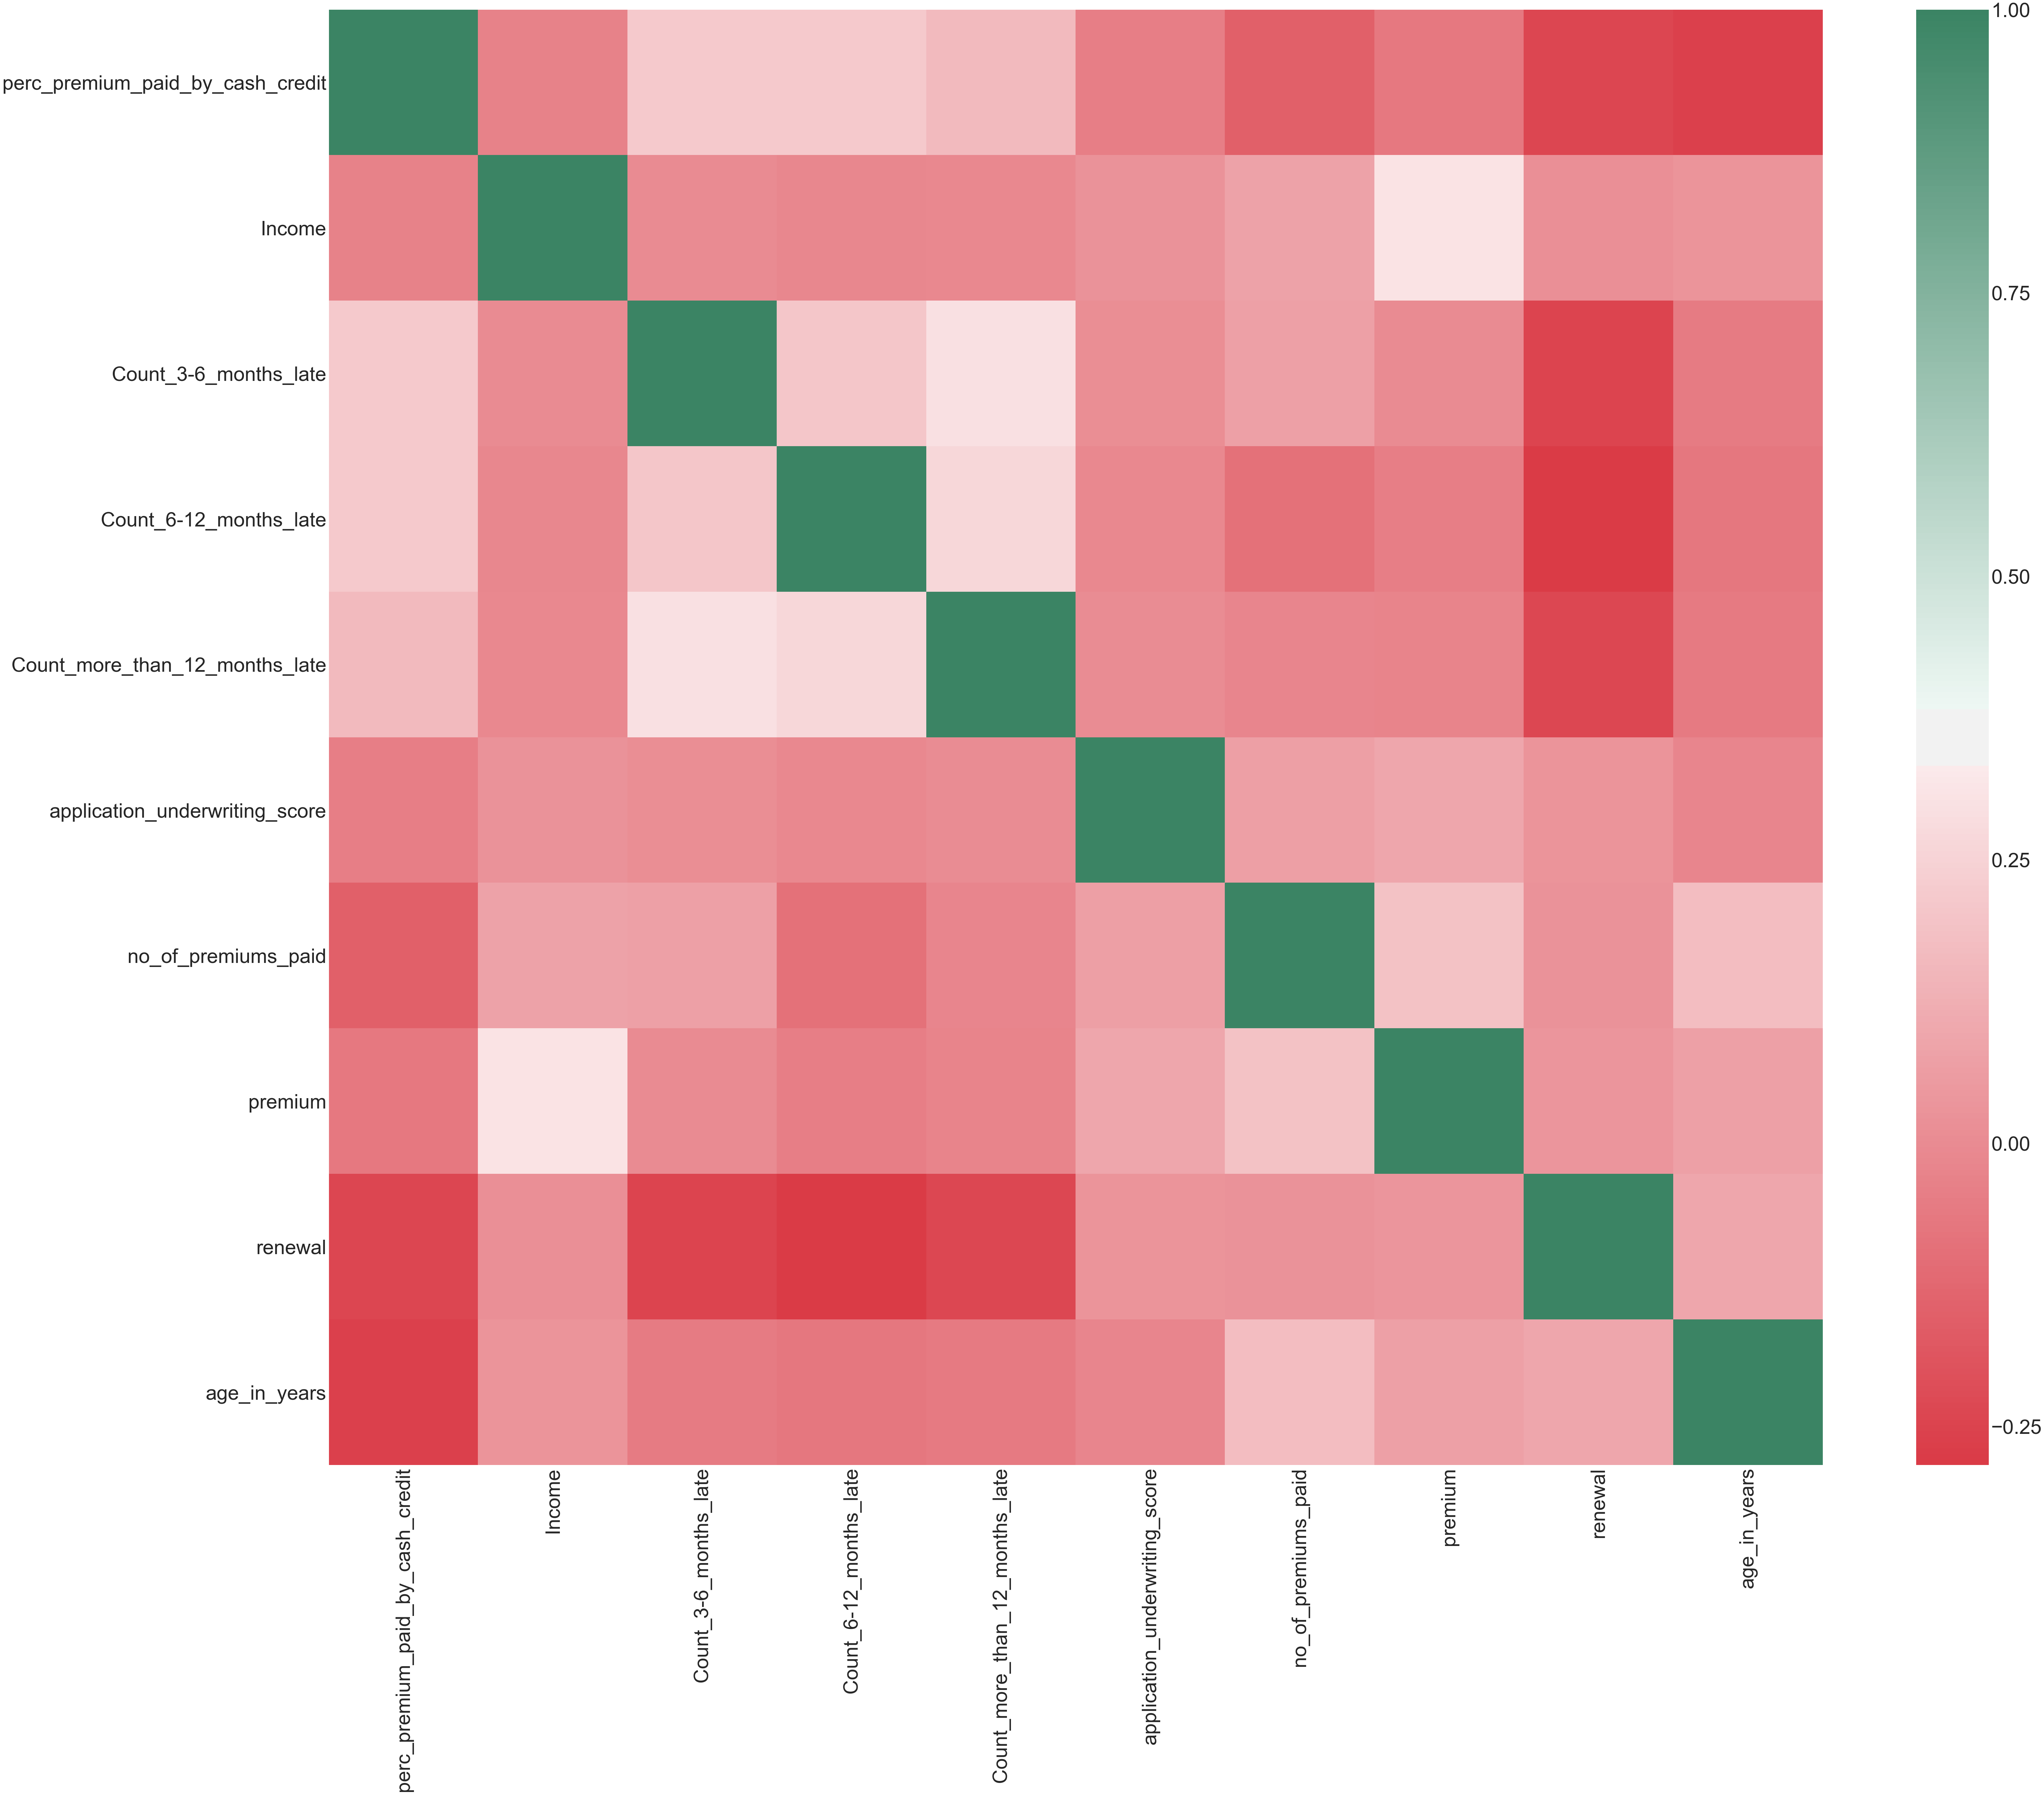

In [60]:
#check for correlation numerical columns
import seaborn as sns
scaler = StandardScaler()
df_scaled = scaler.fit_transform(train[numeric_feats])
corr = pd.DataFrame(df_scaled,columns=list(train[numeric_feats].columns)).corr()
sns.set(font_scale = 6)
plt.subplots( figsize =( 100 , 80 ) )
sns_plot = sns.heatmap(corr,cmap = sns.diverging_palette( 10 , 150 , as_cmap = True ))
sns_plot.figure.savefig(os.path.join(folder,'sigma_cleaned_corr' + '.png'))
plt.show()


In [63]:
del df_scaled,corr
gc.collect()

8942

In [64]:
numeric_feats = [i for i in numeric_feats if train[i].nunique() > 2]

In [61]:
#Check for correlation categorical columns

#use chi square test to find correlated catgeorical features

from scipy.stats import chi2_contingency
df_cat = train[list(train.dtypes[train.dtypes == "object"].index)]
chi2, p_values =[], []
for i in range(len(df_cat.columns)):
    for j in range(len(df_cat.columns)):
        if j > i:
            chitest = chi2_contingency(pd.crosstab(df_cat[df_cat.columns[i]], df_cat[df_cat.columns[j]]))
            chi2.append(chitest[0])
            p_values.append(chitest[1])
        else:      # for same factor pair
            chi2.append(0)
            p_values.append(0)

#Crosstab will create contingency table for the pair of features. 
#Null hypothesis is that the features are independent of each other. 
#If p value is less than significance value, i.e < 0.01 then we can reject Null hypothesis and
#accept alternate hypothesis which stats that the features are related.             

chi2 = np.array(chi2).reshape((df_cat.shape[1],df_cat.shape[1])) # shape it as a matrix
chi2 = pd.DataFrame(chi2, index=df_cat.columns.values, columns=df_cat.columns.values)
p_values = np.array(p_values).reshape((df_cat.shape[1],df_cat.shape[1])) # shape it as a matrix
p_values = pd.DataFrame(p_values, index=df_cat.columns.values, columns=df_cat.columns.values)
chi2


,sourcing_channel,residence_area_type
sourcing_channel,0.0,6.039
residence_area_type,0.0,0.000


In [62]:
p_values

,sourcing_channel,residence_area_type
sourcing_channel,0.0,0.196
residence_area_type,0.0,0.000


In [65]:
del chi2,p_values
gc.collect()

0

In [60]:
p = 0.9
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(p * (1 - p)))
sel.fit(train[numeric_feats])

VarianceThreshold(threshold=0.08999999999999998)

In [61]:
for i, val in enumerate(numeric_feats):
    if sel.variances_[i] < 0.16:
        print(val)

perc_premium_paid_by_cash_credit
Count_more_than_12_months_late


In [62]:
train.perc_premium_paid_by_cash_credit.nunique()

1001

In [63]:
train.Count_more_than_12_months_late.unique()

array([ 0.,  1.,  4.,  2.,  3.,  7.,  5., 11.,  6.,  8.])

In [66]:
#check for skew
from scipy.stats import skew
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats

perc_premium_paid_by_cash_credit      0.893
Income                              109.759
Count_3-6_months_late                 4.153
Count_6-12_months_late               10.359
Count_more_than_12_months_late        7.855
application_underwriting_score       -3.903
no_of_premiums_paid                   1.227
premium                               2.198
age_in_years                          0.223
dtype: float64

In [67]:
skewed_feats[np.abs(skewed_feats) > 0.75]

perc_premium_paid_by_cash_credit      0.893
Income                              109.759
Count_3-6_months_late                 4.153
Count_6-12_months_late               10.359
Count_more_than_12_months_late        7.855
application_underwriting_score       -3.903
no_of_premiums_paid                   1.227
premium                               2.198
dtype: float64

In [68]:
restart_t,restart_test = train.copy(),test.copy()

In [75]:
train,test = restart_t.copy(),restart_test.copy()

In [69]:
#log transform skewed numeric features:

skewed_feats = skewed_feats[np.abs(skewed_feats) > 0.75]
skewed_feats = skewed_feats.index

train[skewed_feats] = train[skewed_feats].apply(lambda x: np.log(1 + np.log(2 + x))) #as we have -1 as minimum value
test[skewed_feats] = test[skewed_feats].apply(lambda x: np.log(1 + np.log(2 + x)))


In [70]:
#Transform features
le = LabelEncoder()
bin_cols = []
for col in cat_col:
    if train[col].nunique() <= 2:
        bin_cols.append(col)
        le.fit(train[col])
        train[col] = le.transform(train[col])        
        test[col] = le.transform(test[col])   

print(bin_cols)

['residence_area_type']


In [71]:
dummy_cols = [i for i in cat_col if i not in bin_cols]

In [72]:
dummy_cols

['sourcing_channel']

In [73]:
train,test = cat_all(train,test,dummy_cols)

Time taken:  0.16251301765441895
Time taken:  0.2506296634674072


In [74]:
not_in_test = []
for col in train.columns:
    if col not in test.columns:
        not_in_test.append(col)
print("Not in test",not_in_test)
not_in_train = []
for col in test.columns:
    if col not in train.columns:
        not_in_train.append(col)
print("Not in train",not_in_train)

Not in test ['renewal']
Not in train []


In [82]:
#train.to_csv(os.path.join(folder,'train_cleaned.csv'))
#test.to_csv(os.path.join(folder,'test_cleaned.csv'))

In [75]:
target = train.pop('renewal')

In [76]:
train.dtypes.value_counts()

float64    8
int64      6
dtype: int64

In [77]:
test.dtypes.value_counts()

float64    8
int64      6
dtype: int64

In [78]:
weight_dict = {0:train.shape[0]/target.value_counts()[0], 1:train.shape[0]/target.value_counts()[1]}

In [79]:
weight_dict

{0: 15.976990796318528, 1: 1.0667690869013426}

In [86]:
model = xgb.sklearn.XGBClassifier(seed=42,max_depth = 6, colsample_bylevel=0.8, 
                                  colsample_bytree=0.8,base_score = 0.5, random_state=seed,
                                  min_child_weight=1, scale_pos_weight = 1)

In [80]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [88]:
cross_val = cross_val_score(model, train, target,cv = kfold,verbose = 5 , scoring = 'roc_auc')

[CV]  ................................................................
[CV] ........................ , score=0.835142007881905, total=   3.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV] ....................... , score=0.8440446195978892, total=   3.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.5s remaining:    0.0s


[CV] ....................... , score=0.8332884242869548, total=   3.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.4s remaining:    0.0s


[CV] ....................... , score=0.8390504591827149, total=   3.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   15.4s remaining:    0.0s


[CV] ....................... , score=0.8465766548058979, total=   3.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   19.2s finished


In [89]:
cross_val.mean() #0.8396204331510724

0.8396204331510724

In [117]:
train = train[imp_cols]
test = test[imp_cols]

In [118]:
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=seed,test_size=0.25)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_pred = scaler.transform(test)

In [119]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(59889, 8) (19964, 8) (59889,) (19964,)


In [83]:
#Baseline model
# Get predictions on the test set
baseline_predictions = np.zeros(y_test.shape)

# Compute baseline
baseline = roc_auc_score(y_test, baseline_predictions)

print("Baseline score is {:.2f}".format(baseline))

Baseline score is 0.50


In [120]:
#consider weight balance as it is imbalanced dataset
model = xgb.sklearn.XGBClassifier(seed=seed,max_depth = 1, colsample_bylevel=0.7,
                                       colsample_bytree=0.7,sample = 0.9,base_score = 0.6,gamma = 0, random_state=seed,
                                  min_child_weight=36, scale_pos_weight = 1)
eval_set = [(X_test_scaled, y_test)]
model.fit(X_train_scaled, y_train, early_stopping_rounds=10, eval_metric="auc", eval_set=eval_set, verbose=True)
#### make predictions for test data
y_pred = model.predict(X_test_scaled)

[0]	validation_0-auc:0.624728
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.736713
[2]	validation_0-auc:0.762936
[3]	validation_0-auc:0.761245
[4]	validation_0-auc:0.761245
[5]	validation_0-auc:0.790964
[6]	validation_0-auc:0.79255
[7]	validation_0-auc:0.792791
[8]	validation_0-auc:0.800326
[9]	validation_0-auc:0.803474
[10]	validation_0-auc:0.802566
[11]	validation_0-auc:0.803612
[12]	validation_0-auc:0.804155
[13]	validation_0-auc:0.803239
[14]	validation_0-auc:0.8028
[15]	validation_0-auc:0.802549
[16]	validation_0-auc:0.802346
[17]	validation_0-auc:0.802346
[18]	validation_0-auc:0.806521
[19]	validation_0-auc:0.80722
[20]	validation_0-auc:0.808118
[21]	validation_0-auc:0.807917
[22]	validation_0-auc:0.808387
[23]	validation_0-auc:0.812475
[24]	validation_0-auc:0.812658
[25]	validation_0-auc:0.814374
[26]	validation_0-auc:0.8141
[27]	validation_0-auc:0.815211
[28]	validation_0-auc:0.814801
[29]	validation_0-auc:0.815096
[30]	validation_0-auc:

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [121]:
#### evaluate predictions
score = roc_auc_score(y_test, y_pred)
print("ROC AUC score: {0:.2f}%".format(score * 100.0)) #54.8%

ROC AUC score: 54.65%


In [89]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
# Error rate : 
err_rate = (fp + fn) / (tp + tn + fn + fp)
print("Error rate  : ", err_rate)
# Accuracy : 
acc_ = (tp + tn) / (tp + tn + fn + fp)
print("Accuracy  : ", acc_)
# Sensitivity : 
sens_ = tp / (tp + fn)
print("Sensitivity  : ", sens_)
# Specificity 
sp_ = tn / (tn + fp)
print("Specificity  : ", sens_)
# False positive rate (FPR)
FPR = fp / (tn + fp)
print("False positive rate  : ", FPR)

Error rate  :  0.06141053897014626
Accuracy  :  0.9385894610298537
Sensitivity  :  0.9947092774690038
Specificity  :  0.9947092774690038
False positive rate  :  0.9001597444089456


### Parameter Tuning

There are in general two ways that you can control overfitting in xgboost :  
* The first way is to directly control model complexity◦This include max_depth, min_child_weight and gamma  
* The second way is to add randomness to make training robust to noise◦This include subsample, colsample_bytree  
* You can also reduce stepsize eta, but needs to remember to increase num_round when you do so


In [ ]:
#XGBoost hyperparameters
'''
max_depth=3, learning_rate=0.1, n_estimators=100, 
                                  objective='binary:logistic', booster='gbtree', n_jobs=4, 
                                  gamma=0, min_child_weight=1, max_delta_step=0, 
                                  subsample=0.8, colsample_bytree=0.8, colsample_bylevel=0.8, 
                                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, 
                                  base_score=0.5, random_state=seed, seed=seed
'''

In [ ]:
'''
Steps:
1. Fix learning rate and number of estimators {'learning_rate' : 0.3, 'n_estimators' : 100}
2. Tune max_depth and min_child_weight 'max_depth':range(3,10,2), 'min_child_weight':range(1,6,2)
3. Tune gamma 'gamma':[i/10.0 for i in range(0,5)]
4. Tune subsample and colsample_bytree   {    'subsample':[i/10.0 for i in range(6,10)],
'colsample_bytree':[i/10.0 for i in range(6,10)]}
5. Reducing Learning Rate in order to reduce overfit
'''

In [122]:
model = xgb.sklearn.XGBClassifier(learning_rate=0.3, n_estimators=100, 
                                  objective='binary:logistic', 
                                  gamma=0, max_delta_step=0, 
                                  subsample=0.9, colsample_bytree=0.7, colsample_bylevel=0.7, 
                                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, 
                                  base_score=0.5, random_state=seed, seed=seed)

param_test1 = {'max_depth':[int(0.1*train.shape[1]),int(0.4*train.shape[1]),int(0.8*train.shape[1])],
               'min_child_weight': [1,8,20,36]} #[i for i in range(5,12,3)]
grid_search1 = GridSearchCV(model, param_grid = param_test1, scoring="roc_auc", n_jobs=4, cv=kfold, verbose=10)
result = grid_search1.fit(train,target)

grid_search1.best_params_,grid_search1.best_score_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    7.5s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   12.0s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   19.0s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   27.3s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   41.1s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:   47.6s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:   47.6s finished


({'max_depth': 3, 'min_child_weight': 20}, 0.840672922134079)

In [123]:
def check_model(model_fn):
    model_fn.fit(X_train_scaled, y_train, early_stopping_rounds=10, eval_metric="auc", eval_set=eval_set, verbose=True)
    #### make predictions for test data
    y_pred = model_fn.predict(X_test_scaled)
    score = roc_auc_score(y_test, y_pred)
    print("ROC AUC score: {0:.2f}%".format(score * 100.0))

In [124]:
model = xgb.sklearn.XGBClassifier(max_depth = 3,learning_rate=0.3, n_estimators=500, 
                                  objective='binary:logistic', 
                                  gamma=0, min_child_weight= 1, max_delta_step=0, 
                                  subsample=0.8, colsample_bytree=0.8, colsample_bylevel=0.8, 
                                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, 
                                  base_score=0.5, random_state=seed, seed=seed)

param_test1 = {'min_child_weight': [24,28,32]} #[i for i in range(5,12,3)]
grid_search1 = GridSearchCV(model, param_grid = param_test1, scoring="roc_auc", n_jobs=4, cv=kfold, verbose=10)
result = grid_search1.fit(train,target)

grid_search1.best_params_,grid_search1.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   33.1s
[Parallel(n_jobs=4)]: Done  10 out of  15 | elapsed:   49.8s remaining:   24.8s
[Parallel(n_jobs=4)]: Done  12 out of  15 | elapsed:   52.9s remaining:   13.2s
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  1.1min finished


({'min_child_weight': 32}, 0.8336994944552567)

In [125]:
model_fin = xgb.sklearn.XGBClassifier(max_depth = 3, min_child_weight = 32,learning_rate=0.3, n_estimators=500, 
                                  objective='binary:logistic', 
                                  gamma=0, max_delta_step=0, 
                                  subsample=0.9, colsample_bytree=0.7, colsample_bylevel=0.7, 
                                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, 
                                  base_score=0.6, random_state=seed, seed=seed)

check_model(model_fin)

[0]	validation_0-auc:0.715068
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.771528
[2]	validation_0-auc:0.818658
[3]	validation_0-auc:0.818335
[4]	validation_0-auc:0.828204
[5]	validation_0-auc:0.827973
[6]	validation_0-auc:0.829906
[7]	validation_0-auc:0.831386
[8]	validation_0-auc:0.832386
[9]	validation_0-auc:0.833071
[10]	validation_0-auc:0.834373
[11]	validation_0-auc:0.834547
[12]	validation_0-auc:0.834379
[13]	validation_0-auc:0.835124
[14]	validation_0-auc:0.836377
[15]	validation_0-auc:0.837057
[16]	validation_0-auc:0.83707
[17]	validation_0-auc:0.837023
[18]	validation_0-auc:0.837202
[19]	validation_0-auc:0.837433
[20]	validation_0-auc:0.837755
[21]	validation_0-auc:0.837815
[22]	validation_0-auc:0.838224
[23]	validation_0-auc:0.838819
[24]	validation_0-auc:0.839455
[25]	validation_0-auc:0.839285
[26]	validation_0-auc:0.839423
[27]	validation_0-auc:0.839613
[28]	validation_0-auc:0.839732
[29]	validation_0-auc:0.839733
[30]	validation_0

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [126]:
model = xgb.sklearn.XGBClassifier(max_depth = 3, min_child_weight = 32,learning_rate=0.3, n_estimators=500, 
                                  objective='binary:logistic', 
                                  max_delta_step=0, 
                                  subsample=0.9, colsample_bytree=0.7, colsample_bylevel=0.7, 
                                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, 
                                  base_score=0.6, random_state=seed, seed=seed)

param_test1 = {'gamma':[i/10.0 for i in range(0,5)]}
grid_search1 = GridSearchCV(model, param_grid = param_test1, scoring="roc_auc", n_jobs=4, cv=kfold, verbose=10)
result = grid_search1.fit(train,target)

grid_search1.best_params_,grid_search1.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   29.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   44.5s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  21 out of  25 | elapsed:  1.4min remaining:   16.0s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  1.6min finished


({'gamma': 0.3}, 0.8349014931502781)

In [127]:
model_fin = xgb.sklearn.XGBClassifier(max_depth = 3, min_child_weight = 32,learning_rate=0.3, n_estimators=500, 
                                  objective='binary:logistic', 
                                  gamma = 0.3,max_delta_step=0, 
                                  subsample=0.9, colsample_bytree=0.7, colsample_bylevel=0.7, 
                                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, 
                                  base_score=0.6, random_state=seed, seed=seed)

check_model(model_fin)

[0]	validation_0-auc:0.715068
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.771528
[2]	validation_0-auc:0.818658
[3]	validation_0-auc:0.818335
[4]	validation_0-auc:0.828204
[5]	validation_0-auc:0.827973
[6]	validation_0-auc:0.829906
[7]	validation_0-auc:0.831386
[8]	validation_0-auc:0.832386
[9]	validation_0-auc:0.833071
[10]	validation_0-auc:0.834373
[11]	validation_0-auc:0.834547
[12]	validation_0-auc:0.834379
[13]	validation_0-auc:0.835124
[14]	validation_0-auc:0.836377
[15]	validation_0-auc:0.837057
[16]	validation_0-auc:0.83707
[17]	validation_0-auc:0.837023
[18]	validation_0-auc:0.837202
[19]	validation_0-auc:0.837433
[20]	validation_0-auc:0.837755
[21]	validation_0-auc:0.837815
[22]	validation_0-auc:0.838224
[23]	validation_0-auc:0.838819
[24]	validation_0-auc:0.839455
[25]	validation_0-auc:0.839285
[26]	validation_0-auc:0.839423
[27]	validation_0-auc:0.839613
[28]	validation_0-auc:0.839732
[29]	validation_0-auc:0.839733
[30]	validation_0

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [128]:
model = xgb.sklearn.XGBClassifier(max_depth = 3, min_child_weight = 32,learning_rate=0.3, n_estimators=500, 
                                  objective='binary:logistic', 
                                  gamma = 0.3,max_delta_step=0,  
                                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, 
                                  base_score=0.6, random_state=seed, seed=seed)

param_test1 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)],
    'colsample_bylevel':[i/10.0 for i in range(6,10)]
}
grid_search1 = GridSearchCV(model, param_grid = param_test1, scoring="roc_auc", n_jobs=4, cv=kfold, verbose=10)
result = grid_search1.fit(train,target)

grid_search1.best_params_,grid_search1.best_score_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   28.8s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   45.5s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  5.1min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  5.8min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  6.7min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  7.5min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  8.9min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 10.0min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed: 11.3min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 12.5min
[Parallel(n_jobs=4)]: Do

({'colsample_bylevel': 0.6, 'colsample_bytree': 0.6, 'subsample': 0.8},
 0.8354471556658033)

In [129]:
model_fin = xgb.sklearn.XGBClassifier(max_depth = 3, min_child_weight = 32,learning_rate=0.3, n_estimators=500, 
                                  objective='binary:logistic', 
                                  gamma = 0.3,max_delta_step=0, 
                                  subsample=0.8, colsample_bytree=0.6, colsample_bylevel=0.6, 
                                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, 
                                  base_score=0.6, random_state=seed, seed=seed)

check_model(model_fin)

[0]	validation_0-auc:0.716166
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.776225
[2]	validation_0-auc:0.811979
[3]	validation_0-auc:0.812546
[4]	validation_0-auc:0.826969
[5]	validation_0-auc:0.827661
[6]	validation_0-auc:0.829286
[7]	validation_0-auc:0.832962
[8]	validation_0-auc:0.833244
[9]	validation_0-auc:0.833522
[10]	validation_0-auc:0.835109
[11]	validation_0-auc:0.835859
[12]	validation_0-auc:0.835887
[13]	validation_0-auc:0.83618
[14]	validation_0-auc:0.836228
[15]	validation_0-auc:0.837065
[16]	validation_0-auc:0.836818
[17]	validation_0-auc:0.836402
[18]	validation_0-auc:0.836802
[19]	validation_0-auc:0.837579
[20]	validation_0-auc:0.837631
[21]	validation_0-auc:0.838012
[22]	validation_0-auc:0.83815
[23]	validation_0-auc:0.838207
[24]	validation_0-auc:0.838223
[25]	validation_0-auc:0.838228
[26]	validation_0-auc:0.838499
[27]	validation_0-auc:0.839021
[28]	validation_0-auc:0.839
[29]	validation_0-auc:0.839151
[30]	validation_0-auc

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [134]:
model = xgb.sklearn.XGBClassifier(max_depth = 3, min_child_weight = 32,learning_rate=0.3, n_estimators=500, 
                                  objective='binary:logistic', 
                                  gamma = 0.3,max_delta_step=0, 
                                  subsample=0.8, colsample_bytree=0.6, colsample_bylevel=0.6, 
                                  reg_alpha=0, reg_lambda=1, random_state=seed, seed=seed)

param_test1 = {
    'base_score':[i/10.0 for i in range(1,4)],
    'scale_pos_weight':[1+i*3 for i in range(0,1)]
}
grid_search1 = GridSearchCV(model, param_grid = param_test1, scoring="roc_auc", n_jobs=4, cv=kfold, verbose=10)
result = grid_search1.fit(train,target)

grid_search1.best_params_,grid_search1.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   26.5s
[Parallel(n_jobs=4)]: Done  10 out of  15 | elapsed:   40.0s remaining:   20.0s
[Parallel(n_jobs=4)]: Done  12 out of  15 | elapsed:   42.9s remaining:   10.6s
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   51.9s finished


({'base_score': 0.1, 'scale_pos_weight': 1}, 0.8356191824883132)

In [135]:
model_fin = xgb.sklearn.XGBClassifier(max_depth = 3, min_child_weight = 32,learning_rate=0.3, n_estimators=500, 
                                  objective='binary:logistic', 
                                  gamma = 0.3,max_delta_step=0, 
                                  subsample=0.8, colsample_bytree=0.6, colsample_bylevel=0.6, 
                                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, 
                                  base_score=0.1, random_state=seed, seed=seed)

check_model(model_fin)

[0]	validation_0-auc:0.691455
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.780033
[2]	validation_0-auc:0.804066
[3]	validation_0-auc:0.806851
[4]	validation_0-auc:0.823243
[5]	validation_0-auc:0.826269
[6]	validation_0-auc:0.82907
[7]	validation_0-auc:0.830845
[8]	validation_0-auc:0.830314
[9]	validation_0-auc:0.83145
[10]	validation_0-auc:0.831882
[11]	validation_0-auc:0.833462
[12]	validation_0-auc:0.834383
[13]	validation_0-auc:0.834534
[14]	validation_0-auc:0.835521
[15]	validation_0-auc:0.836445
[16]	validation_0-auc:0.837107
[17]	validation_0-auc:0.836832
[18]	validation_0-auc:0.837103
[19]	validation_0-auc:0.837826
[20]	validation_0-auc:0.837783
[21]	validation_0-auc:0.837779
[22]	validation_0-auc:0.837963
[23]	validation_0-auc:0.838123
[24]	validation_0-auc:0.838074
[25]	validation_0-auc:0.838349
[26]	validation_0-auc:0.838329
[27]	validation_0-auc:0.838757
[28]	validation_0-auc:0.838576
[29]	validation_0-auc:0.838526
[30]	validation_0-

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [136]:
model = xgb.sklearn.XGBClassifier(max_depth = 3, min_child_weight = 32,n_estimators=500, 
                                  objective='binary:logistic', 
                                  gamma = 0.3,max_delta_step=0, 
                                  subsample=0.8, colsample_bytree=0.6, colsample_bylevel=0.6, 
                                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, 
                                  base_score=0.1, random_state=seed, seed=seed)

param_test1 = {
    'learning_rate':[i/40.0 for i in range(1,4)]
}
grid_search1 = GridSearchCV(model, param_grid = param_test1, scoring="roc_auc", n_jobs=4, cv=kfold, verbose=10)
result = grid_search1.fit(train,target)

grid_search1.best_params_,grid_search1.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   26.1s
[Parallel(n_jobs=4)]: Done  10 out of  15 | elapsed:   39.2s remaining:   19.5s
[Parallel(n_jobs=4)]: Done  12 out of  15 | elapsed:   41.3s remaining:   10.3s
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   50.7s finished


({'learning_rate': 0.05}, 0.842134450617828)

In [138]:
model_fin = xgb.sklearn.XGBClassifier(max_depth = 3, min_child_weight = 32,learning_rate= 0.05, n_estimators=2000, 
                                  objective='binary:logistic', 
                                  gamma = 0.3,max_delta_step=0, 
                                  subsample=0.8, colsample_bytree=0.6, colsample_bylevel=0.6, 
                                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, 
                                  base_score=0.1, random_state=seed, seed=seed)

check_model(model_fin)

[0]	validation_0-auc:0.691455
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.764471
[2]	validation_0-auc:0.796501
[3]	validation_0-auc:0.795934
[4]	validation_0-auc:0.814869
[5]	validation_0-auc:0.819097
[6]	validation_0-auc:0.82379
[7]	validation_0-auc:0.825815
[8]	validation_0-auc:0.828357
[9]	validation_0-auc:0.830041
[10]	validation_0-auc:0.828958
[11]	validation_0-auc:0.829137
[12]	validation_0-auc:0.830548
[13]	validation_0-auc:0.831081
[14]	validation_0-auc:0.83112
[15]	validation_0-auc:0.831156
[16]	validation_0-auc:0.831441
[17]	validation_0-auc:0.831814
[18]	validation_0-auc:0.832872
[19]	validation_0-auc:0.833368
[20]	validation_0-auc:0.833451
[21]	validation_0-auc:0.834205
[22]	validation_0-auc:0.834208
[23]	validation_0-auc:0.834656
[24]	validation_0-auc:0.834713
[25]	validation_0-auc:0.834537
[26]	validation_0-auc:0.834288
[27]	validation_0-auc:0.834499
[28]	validation_0-auc:0.834887
[29]	validation_0-auc:0.8353
[30]	validation_0-au

C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [141]:
model = xgb.sklearn.XGBClassifier(max_depth = 3, min_child_weight = 32,learning_rate=0.05, n_estimators=10000, 
                                  objective='binary:logistic', 
                                  gamma = 0.3,max_delta_step=0, 
                                  subsample=0.8, colsample_bytree=0.6, colsample_bylevel=0.6, 
                                  reg_alpha=0, reg_lambda=1, scale_pos_weight=1, 
                                  base_score=0.1, random_state=seed, seed=seed)

In [142]:
model.fit(X_train_scaled, y_train, early_stopping_rounds=20, eval_metric="auc", eval_set=eval_set, verbose=True)
#### make predictions for test data
y_pred = model.predict(X_test_scaled)
score = roc_auc_score(y_test, y_pred)
print("ROC AUC score: {0:.2f}%".format(score * 100.0)) #56.53%

[0]	validation_0-auc:0.691455
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.764471
[2]	validation_0-auc:0.796501
[3]	validation_0-auc:0.795934
[4]	validation_0-auc:0.814869
[5]	validation_0-auc:0.819097
[6]	validation_0-auc:0.82379
[7]	validation_0-auc:0.825815
[8]	validation_0-auc:0.828357
[9]	validation_0-auc:0.830041
[10]	validation_0-auc:0.828958
[11]	validation_0-auc:0.829137
[12]	validation_0-auc:0.830548
[13]	validation_0-auc:0.831081
[14]	validation_0-auc:0.83112
[15]	validation_0-auc:0.831156
[16]	validation_0-auc:0.831441
[17]	validation_0-auc:0.831814
[18]	validation_0-auc:0.832872
[19]	validation_0-auc:0.833368
[20]	validation_0-auc:0.833451
[21]	validation_0-auc:0.834205
[22]	validation_0-auc:0.834208
[23]	validation_0-auc:0.834656
[24]	validation_0-auc:0.834713
[25]	validation_0-auc:0.834537
[26]	validation_0-auc:0.834288
[27]	validation_0-auc:0.834499
[28]	validation_0-auc:0.834887
[29]	validation_0-auc:0.8353
[30]	validation_0-au

Stopping. Best iteration:
[238]	validation_0-auc:0.841124

ROC AUC score: 56.39%


C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [143]:
preds = model.predict_proba(X_pred)[:,1]#.round(4)

In [200]:
#any policy having probability more than 60 -80 % can be converted to renewal by providing incentives

In [144]:
inc = pd.DataFrame(restart_test.premium)

In [145]:
inc['probab'] = preds

In [146]:
profit_sharing = 0.5

In [147]:
inc['incentive'] = round(inc.premium * profit_sharing * (1 - inc['probab']),0).astype(int)
inc['incentive'] = inc.incentive.apply(lambda x: 1000 if x > 1000 else x)

In [148]:
inc['efforts'] = 10 * (1 - np.exp(-1*inc['incentive']/400))
inc['renewal_p'] = 20 * (1 - np.exp(-1*inc['efforts']/5))/100
inc['total_revenue'] = (inc['renewal_p'])*inc['premium'] - inc['incentive']

In [149]:
inc.head()

,premium,probab,incentive,efforts,renewal_p,total_revenue
id,,,,,,
649,3300,0.991,15,0.368,0.014,31.838
81136,11700,0.983,101,2.231,0.072,741.401
70762,11700,0.818,1000,9.179,0.168,966.814
53935,5400,0.975,67,1.542,0.053,219.646
15476,9600,0.961,186,3.719,0.105,821.352


In [150]:
inc['total_revenue'].sum()

31001209.347187728

In [ ]:
#incentives based or prob

In [151]:
sub = pd.DataFrame({'id':test.index, 'renewal':preds,'incentives':inc['incentive'] })
sub = sub[['id','renewal','incentives']]
sub.to_csv(os.path.join(folder,'submission22.csv'), index=False)

In [109]:
imps = pd.DataFrame(model.feature_importances_,index = train.columns, columns = [ 'Importance' ])

In [110]:
imps.sort_values(by = 'Importance',ascending=False,inplace=True)

In [114]:
imps[:8].T

,perc_premium_paid_by_cash_credit,Count_6-12_months_late,Count_3-6_months_late,no_of_premiums_paid,Count_more_than_12_months_late,age_in_years,Income,application_underwriting_score
Importance,0.214,0.156,0.149,0.123,0.104,0.104,0.078,0.071


In [115]:
imp_cols = list(imps[:8].index)

In [116]:
np.array(imp_cols)

array(['perc_premium_paid_by_cash_credit', 'Count_6-12_months_late',
       'Count_3-6_months_late', 'no_of_premiums_paid',
       'Count_more_than_12_months_late', 'age_in_years', 'Income',
       'application_underwriting_score'], dtype='<U32')